In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
%matplotlib inline

Part 1 ‑ Exploratory data analysis

In [2]:
df = pd.read_json('logins.json')

In [3]:
print(df.head())
print(df.tail())

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
               login_time
93137 1970-04-13 18:50:19
93138 1970-04-13 18:43:56
93139 1970-04-13 18:54:02
93140 1970-04-13 18:57:38
93141 1970-04-13 18:54:23


In [4]:
df['n'] = 1
df.set_index('login_time', inplace=True)
logins15 = df.resample('15T').sum()

In [5]:
logins15.describe()

,n
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


In [6]:
logins15.sort_values('n', ascending=False).head(10)

,n
login_time,
1970-03-01 04:30:00,73
1970-04-04 05:30:00,66
1970-04-04 01:30:00,64
1970-04-04 01:15:00,63
1970-04-01 23:30:00,60
1970-04-04 05:00:00,60
1970-04-04 04:45:00,59
1970-04-04 05:15:00,59
1970-04-04 01:45:00,56


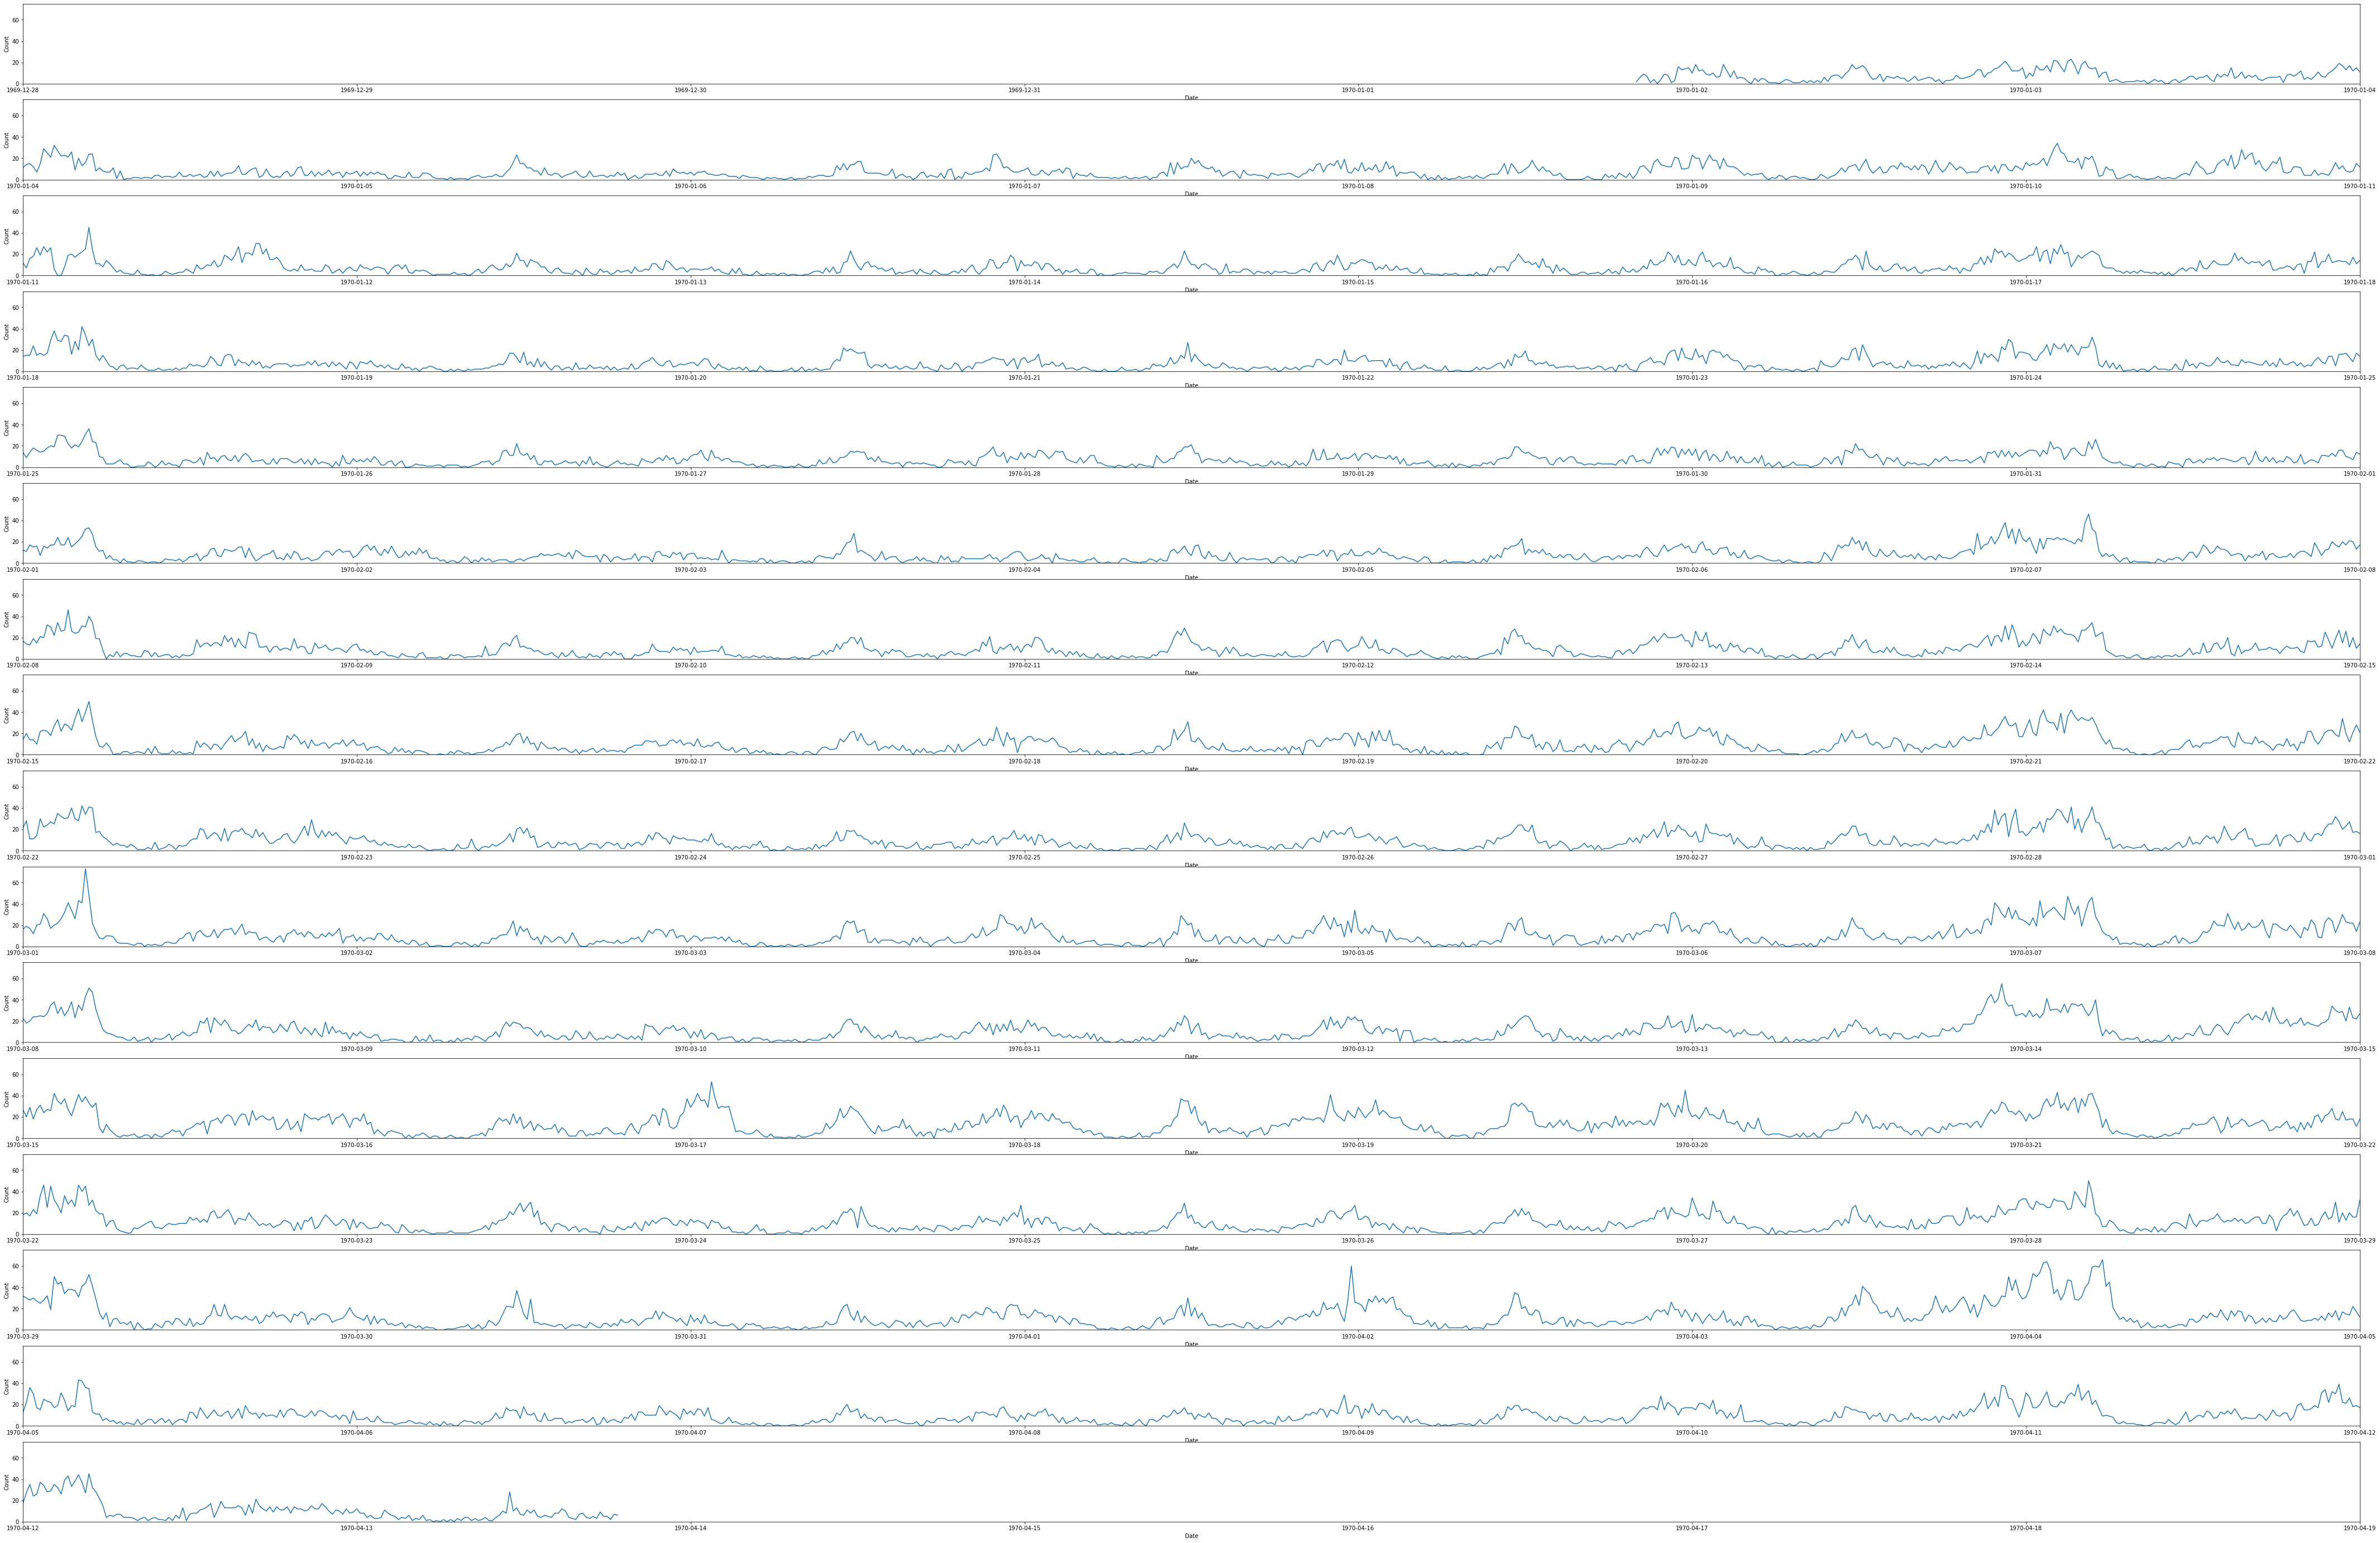

In [23]:
start=min(df.index).date()
lstart= start - timedelta(days=4)

plt.figure(figsize= [75,50])

weeks = np.arange(1,17)

for i in weeks:
    end=start + timedelta(days=7)
    lend = end - timedelta(days=4)
    plt.subplot(max(weeks),1,i)
    plt.ylim(0,75)
    plt.xlim(lstart, lend)
    plt.plot(logins15)
    start = end
    lstart = lend
    plt.xlabel('Date')
    plt.ylabel('Count')
plt.show()

<font color='green'> There appear to be weekly cycles with Thursday night into Friday morning typically having the highest number of users logging in. Sunday night into Monday morning and Monday night into Tuesday morning typically see the lowest number of users logging in. The night of April saw the highest number of logins.

Part 2 ‑ Experiment and metrics design

<font color='green'>1. I would choose the number of tolls paid as the key measure of success of this experiment because this directly indicates that drivers are crossing between the two cities.

<font color='green'>2. I would implement this by relying on electronic toll collection as drivers must register in order to pay electronically. This will allow know or obtain pertinent driver partner details and track which driver partner is crossing the bridge, when, and in what direction. I will allow registration of a sample of vehicles from each driver partner to register for reimbursement to establish my sample and control populations. I would perform a paired T test to determine if there is a significant difference between the control and the sample. If significant I would interpret the results as the experiment successfully showing that reimbursing the tolls encourages driver partners to service both cities. I would recommend the city reimburse additional vehicles as needed or experiment with partial discounts. Caveats of the experiment include the possibility that it may not be apparent if a driver is crossing the bridge for work or for personal reasons.

Part 3 ‑ Predictive modeling

In [8]:
df2 = pd.read_json('ultimate_data_challenge.json')

In [9]:
df2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [11]:
df2.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [12]:
df2.avg_rating_of_driver.fillna(np.mean(df2.avg_rating_of_driver))

0        4.700000
1        5.000000
2        4.300000
3        4.600000
4        4.400000
           ...   
49995    5.000000
49996    4.601559
49997    5.000000
49998    3.000000
49999    4.601559
Name: avg_rating_of_driver, Length: 50000, dtype: float64

In [13]:
#Convert date strings to date type
df2['signup_date']=pd.to_datetime(df2.signup_date).dt.date
df2['last_trip_date']=pd.to_datetime(df2.last_trip_date).dt.date

#Fill in missing values with average of the average ratings
df2['avg_rating_of_driver']=df2.avg_rating_of_driver.fillna(np.mean(df2.avg_rating_of_driver))
df2['avg_rating_by_driver']=df2.avg_rating_by_driver.fillna(np.mean(df2.avg_rating_by_driver))

df2['phone']=df2.phone.fillna('Unknown')

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [14]:
# Target is if the user made a trip within the last 30 days (Retained)
last_day = max(df2.last_trip_date)

df2['retained'] = (last_day - df2.last_trip_date) <= timedelta(days=30)

df2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [15]:
print('Percent of users retained:' , len(df2.retained[df2.retained == True])/len(df2.retained))

Percent of users retained: 0.37608


In [16]:
def objects(dataframe):
    objectlist = dataframe.dtypes[dataframe.dtypes == 'object'].index
    return objectlist

def numbers(dataframe):
    objectlist = dataframe.dtypes[dataframe.dtypes != 'object'].index
    return objectlist

In [17]:
object_list = objects(df2)
numbers_list = numbers(df2)
print(object_list)
print(numbers_list)

Index(['city', 'signup_date', 'last_trip_date', 'phone'], dtype='object')
Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retained'],
      dtype='object')


In [18]:
X_cat = df2[['phone','city']]
X_cont = df2[numbers_list].drop('retained',axis=1)
y = df2.retained

[]

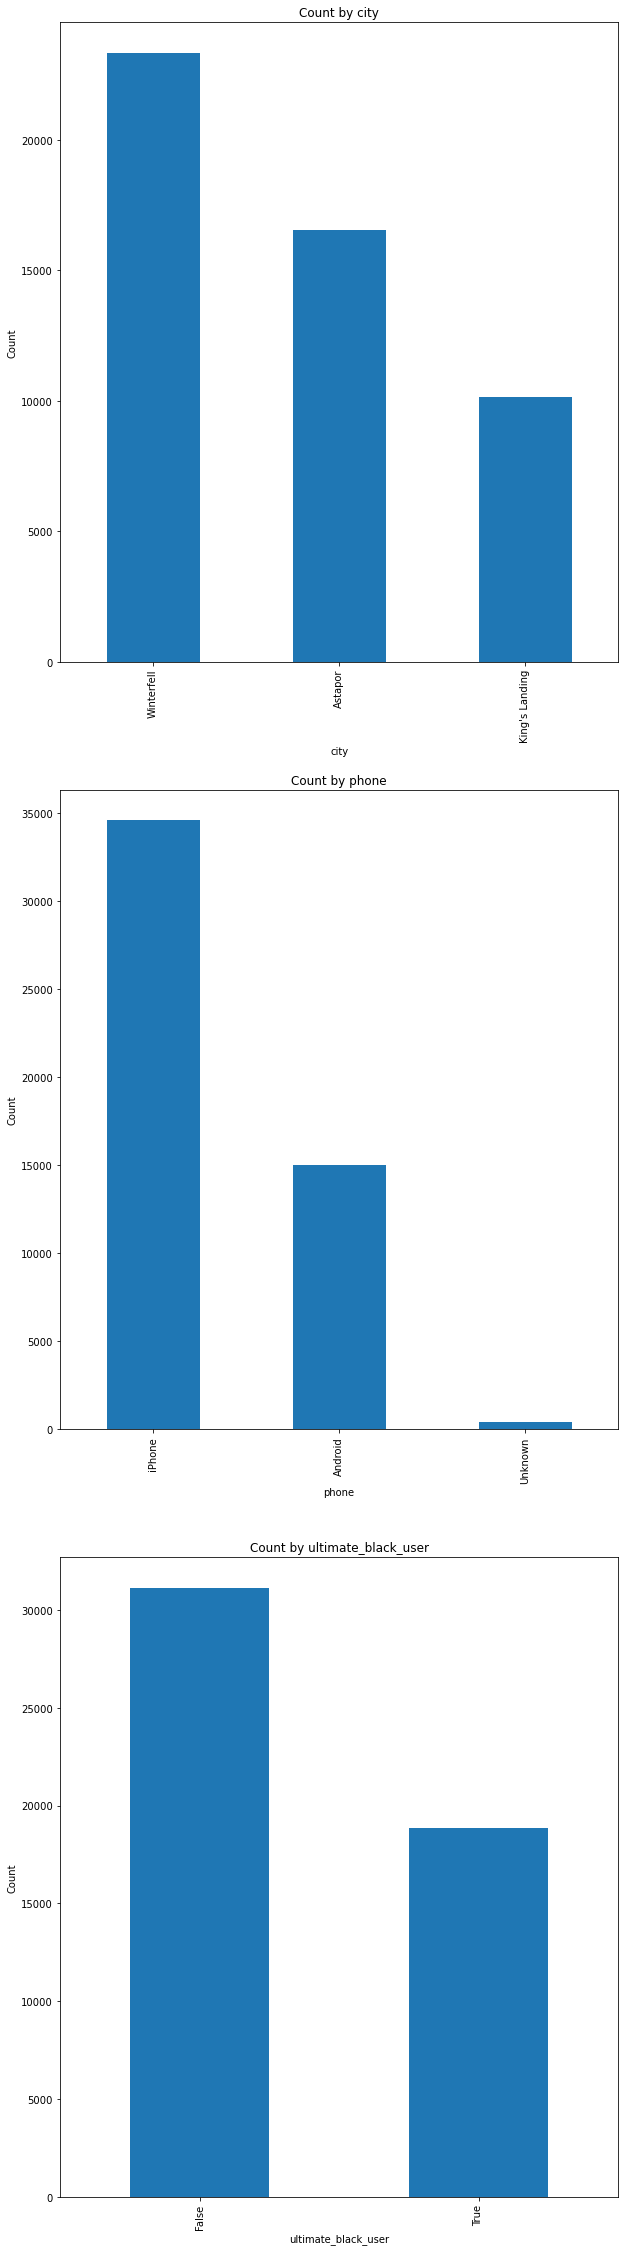

In [35]:
list = ['city','phone','ultimate_black_user']
counter=1
plt.figure(figsize=(10,40))

for i in list:
    plt.subplot(len(list), 1, counter)
    df2[i].value_counts().plot(kind='bar')
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.title('Count by ' + i)
    counter= counter + 1
plt.plot()

[]

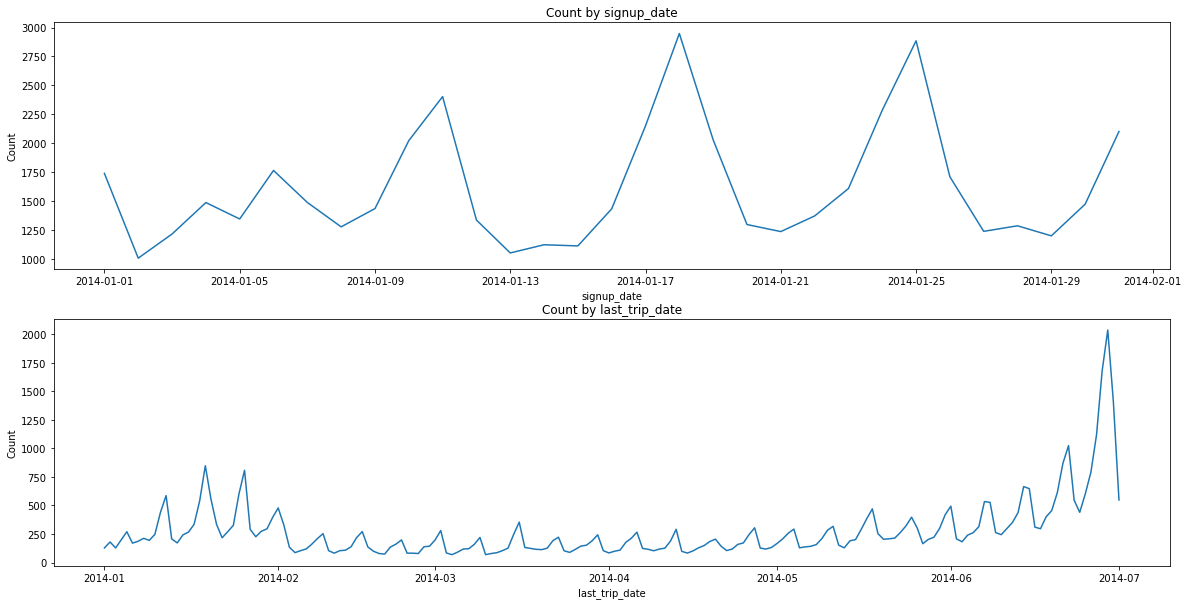

In [27]:
list = ['signup_date','last_trip_date']
counter=1
plt.figure(figsize=(20,10))

for i in list:
    plt.subplot(len(list), 1, counter)
    df2[i].value_counts().plot(kind='line')
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.title('Count by ' + i)
    counter= counter + 1
plt.plot()

[]

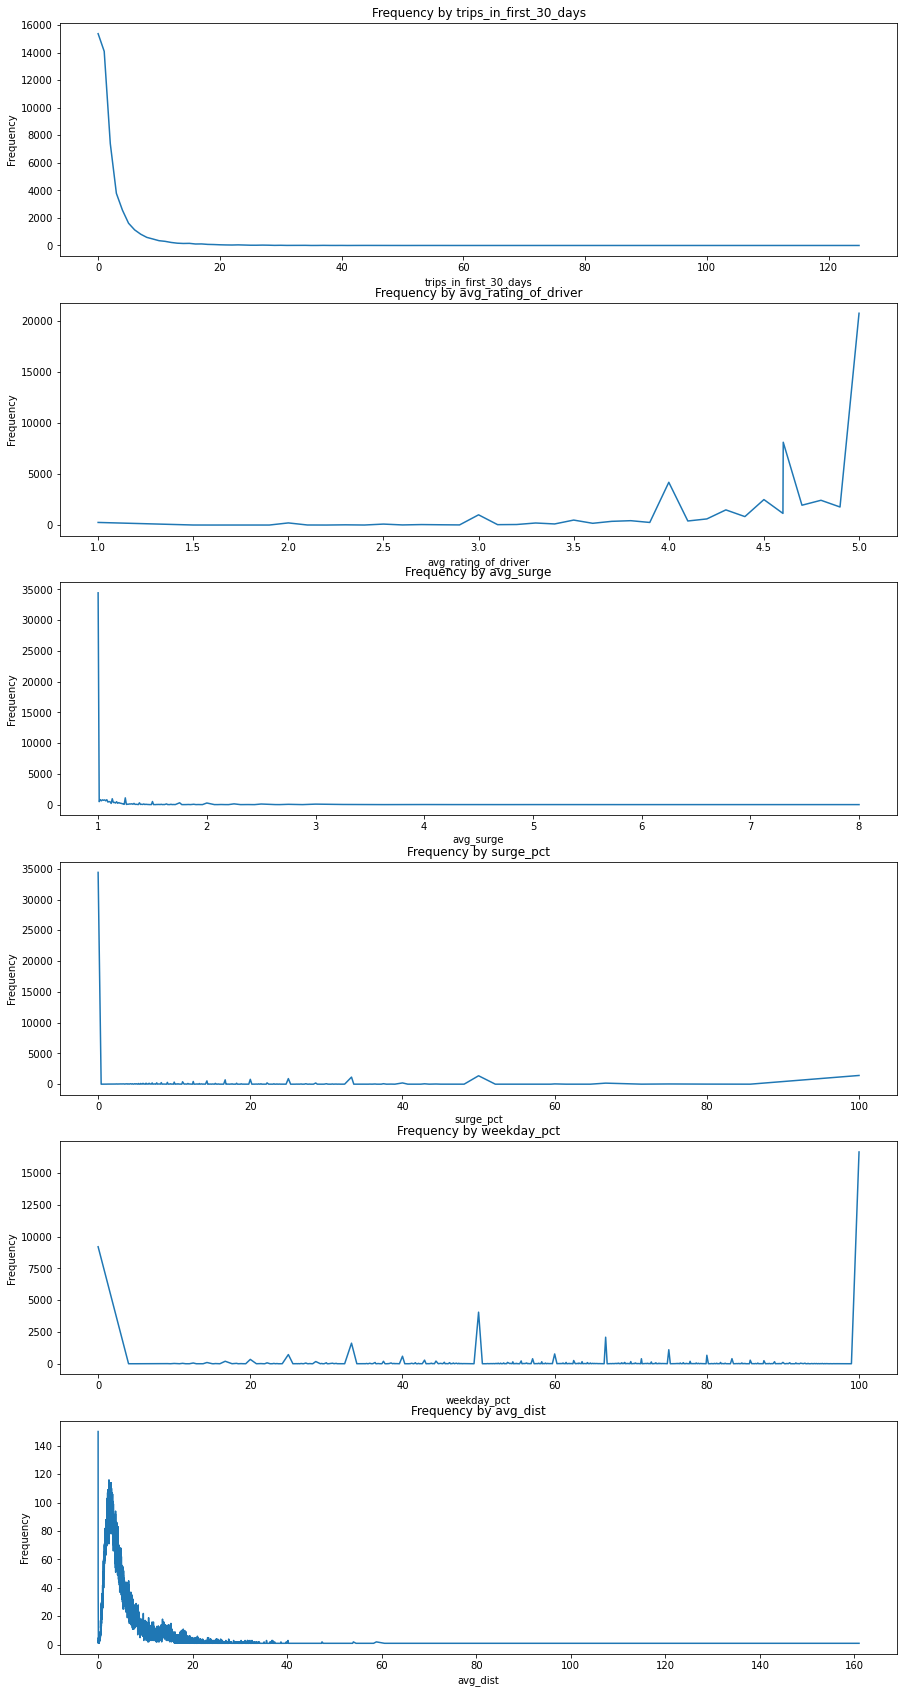

In [28]:
list = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist']
counter=1
plt.figure(figsize=(15,30))

for i in list:
    plt.subplot(len(list), 1, counter)
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.title('Frequency by '+ i)
    df2[i].value_counts().sort_index(ascending=False).plot(kind='line')
    counter= counter + 1
plt.plot()

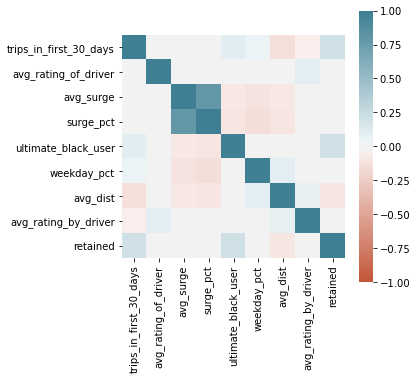

In [36]:
plt.figure(figsize=(5,5))
sns.heatmap(pd.concat([X_cont,y], axis=1).corr(),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)

In [50]:
cat_code = pd.DataFrame()
X_cat["phone"] = X_cat["phone"].astype('category')
cat_code['phone_cat'] = X_cat['phone'].cat.codes
X_cat["city"] = X_cat["city"].astype('category')
cat_code['city'] = X_cat['city'].cat.codes
cat_code.head()

<ipython-input-50-21150cb3ffa9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat["phone"] = X_cat["phone"].astype('category')
<ipython-input-50-21150cb3ffa9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat["city"] = X_cat["city"].astype('category')


,phone_cat,city
0,2,1
1,0,0
2,2,0
3,2,1
4,0,2
...,...,...
49995,2,1
49996,2,0
49997,0,2
49998,2,0


In [57]:
X_cont.ultimate_black_user[X_cont.ultimate_black_user==True] = 1
X_cont.ultimate_black_user[X_cont.ultimate_black_user==False] = 0
y[y==True] = 1
y[y==False] = 0
y.head()

<ipython-input-57-feb49abca469>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cont.ultimate_black_user[X_cont.ultimate_black_user==True] = 1


0    1.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: retained, dtype: float64

In [58]:
X = pd.concat([cat_code,X_cont], axis=1)
X.head()

,phone_cat,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,2,1,4,4.7,1.10,15.4,1.0,46.2,3.67,5.0
1,0,0,0,5.0,1.00,0.0,0.0,50.0,8.26,5.0
2,2,0,3,4.3,1.00,0.0,0.0,100.0,0.77,5.0
3,2,1,9,4.6,1.14,20.0,1.0,80.0,2.36,4.9
4,0,2,14,4.4,1.19,11.8,0.0,82.4,3.13,4.9


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [107]:
#Logistic Regression

lr = LogisticRegression(random_state=0, max_iter=500)  
lr.fit(X_train, y_train)
result1 = lr.predict(X_train)
result2 = lr.predict(X_test)

print(accuracy_score(y_train, result1))
print(accuracy_score(y_test, result2))

0.694575
0.6981


In [110]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()  
knn.fit(X_train, y_train)
result1 = knn.predict(X_train)
result2 = knn.predict(X_test)

print(accuracy_score(y_train, result1))
print(accuracy_score(y_test, result2))

0.816425
0.7479


In [116]:
#Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gn = GaussianNB()  
gn.fit(X_train, y_train)
result1 = gn.predict(X_train)
result2 = gn.predict(X_test)

print(accuracy_score(y_train, result1))
print(accuracy_score(y_test, result2))

0.68295
0.6857


In [118]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()  
rfc.fit(X_train, y_train)
result1 = rfc.predict(X_train)
result2 = rfc.predict(X_test)

print(accuracy_score(y_train, result1))
print(accuracy_score(y_test, result2))

0.99675
0.7601


In [82]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score

In [111]:
confusion_matrix(y_train, result1)

array([[21750,  3195],
       [ 4148, 10907]], dtype=int64)

In [112]:
knn = KNeighborsClassifier()
params = {'weights':['uniform','distance']
          ,'algorithm':['auto', 'ball_tree','kd_tree','brute']
         }
clf = GridSearchCV(knn, params, scoring='accuracy', cv = 5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [113]:
accuracy_score(y_train, clf.predict(X_train))

0.816425

In [114]:
accuracy_score(y_test, clf.predict(X_test))

0.7479

In [115]:
clf.best_params_

{'algorithm': 'auto', 'weights': 'uniform'}

In [141]:
rfc = RandomForestClassifier()
params = {'max_depth':[8, 10, 12, 14]
          ,'min_weight_fraction_leaf':[0, 0.2, 0.4]}
clf = GridSearchCV(rfc, params, scoring='accuracy', cv = 5)
clf.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 10, 12, 14],
                         'min_weight_fraction_leaf': [0, 0.2, 0.4]},
             scoring='accuracy')

In [142]:
accuracy_score(y_train, clf.predict(X_train))

0.84175

In [143]:
accuracy_score(y_test, clf.predict(X_test))

0.7867

In [144]:
clf.best_params_

{'max_depth': 12, 'min_weight_fraction_leaf': 0}

1. 
Most users use iPhones.
Most users take trips in Winterfell.
Most users did not take an Ultimate Black in their first 30 days.
It appears that many users who have stopped using the servicw for a little under a month will not return.

Percent of users retained: 0.37608

2. I chose to test several classification algorithms and score them based on accuracy. The best two algorithms (K nearest neighbors and random forest) performed similarly well; therefore, I tuned them both and chose the best one. The final model has an accuracy of 78.7%.

3. Ultimate might leverage the insights gained to improve it's long-term rider retention by implementing changes aimed at keeping users around for more than one month. They can also create promotions and target each group pro-actively (i.e. offers for those likely to leave and rewards for those who are likely to stay.) They may also wish to promote the Ultimate Black trips more as there appears to be some positive correlation between users who take and and users who continue to use their services.